In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', 300)

In [3]:
# pip install streamlit

In [2]:
colorcode=pd.read_csv('../data/processed/color_code.csv',index_col=0)
ibucode=pd.read_csv('../data/processed/IBU_code.csv',index_col=0)
colorcode

,Style,Color_code
0,Wheat,0
1,Pale Lager/Blonde Ale,1
2,Pale Ale,2
3,Strong Ale,3
4,Brown Ale,4
5,Stout/Porter,5


In [13]:
ibucode

,Style,IBU_code
0,Wheat,0
1,Pale Lager/Blonde Ale,1
2,Brown Ale,2
3,Strong Ale,3
4,Stout/Porter,4
5,Pale Ale,5


In [4]:
beer=pd.read_csv('../data/processed/final_dataset.csv',index_col=0)
beer.head()

,Style,StyleID,ABV,IBU,Color,Simple_style,Style_color
Name,,,,,,,
Vanilla Cream Ale,Cream Ale,45,5.48,17.65,4.83,Pale Lager/Blonde Ale,1
Zombie Dust Clone - EXTRACT,American IPA,7,5.91,59.25,8.98,Pale Ale,2
Zombie Dust Clone - ALL GRAIN,American IPA,7,5.80,54.48,8.50,Pale Ale,2
Bakke Brygg Belgisk Blonde 50 l,Belgian Blond Ale,20,6.48,17.84,4.57,Pale Lager/Blonde Ale,1
Sierra Nevada Pale Ale Clone,American Pale Ale,10,5.58,40.12,8.00,Pale Ale,2


In [4]:
beer['Simple_style'].value_counts(normalize=True) #drop lower count ones?

Simple_style
Pale Ale                 0.523174
Pale Lager/Blonde Ale    0.168831
Stout/Porter             0.148680
Wheat                    0.076118
Strong Ale               0.050816
Brown Ale                0.032382
Name: proportion, dtype: float64

### Split train/test and save it in separate csv files

In [5]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(beer,test_size=0.25,random_state=42) #stratify

In [6]:
#exporting train & test before scaling
# train.to_csv('../data/train/train.csv')
# test.to_csv('../data/test/test.csv')

In [9]:
test['Style_color'].value_counts()

Style_color
2    7439
1    2439
5    2176
0    1055
3     713
4     446
Name: count, dtype: int64

### Setting the Style_color as the target column: first option

In [10]:
X_train=train[['ABV','IBU','Color']]
X_test=test[['ABV','IBU','Color']]

#First experiment with color code
yc_train=train['Style_color']
yc_test=test['Style_color']

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

(The scores were lower when scaling the data, both with MinMaxScaler and StandardScaler)

In [64]:
# Xtrain_scaled=train.copy()
# Xtest_scaled=test.copy()
# col_toscale=['ABV', 'IBU', 'Color']

In [73]:
# Xtrain_scaled[col_toscale] = scaler.fit_transform(train[col_toscale])
# Xtest_scaled[col_toscale] = scaler.fit_transform(test[col_toscale])

In [8]:
yc_test.value_counts()
# yi_test.value_counts()

Style_color
2    6086
5    1682
1    1308
0     852
3     623
4     407
Name: count, dtype: int64

In [9]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, yc_train)

In [10]:
from sklearn.linear_model import LogisticRegression
lr1 = LogisticRegression(max_iter=100000)

In [11]:
lr1.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=100000)

In [19]:
import yaml
import os

lr1_params=lr1.get_params()
# lr1_params

In [18]:
current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'lr1_config.yaml'), 'w') as file:
    yaml.dump(lr1_params, file, default_flow_style=False)

In [12]:
predictions = lr1.predict(X_test)
predicions_proba = lr1.predict_proba(X_test)
# predicions_proba

### Evaluation
With Style_color as target

In [13]:
from sklearn.metrics import (multilabel_confusion_matrix, precision_score,recall_score,
                             f1_score, accuracy_score,confusion_matrix, classification_report)

print('accuracy_score',accuracy_score(yc_test, predictions))
print('precision_score',precision_score(yc_test, predictions, average='weighted'))
print('f1_score',f1_score(yc_test, predictions, average='weighted'))
print('recall_score',recall_score(yc_test, predictions, average='weighted'))
# print(classification_report(yc_test, predictions))

accuracy_score 0.7938043173535184
precision_score 0.8478685461005644
f1_score 0.8110785042994997
recall_score 0.7938043173535184


In [131]:
# cm=multilabel_confusion_matrix(yc_test, predictions)
# cm

In [14]:
cm = confusion_matrix(yc_test, predictions,normalize='true')
# print(cm)

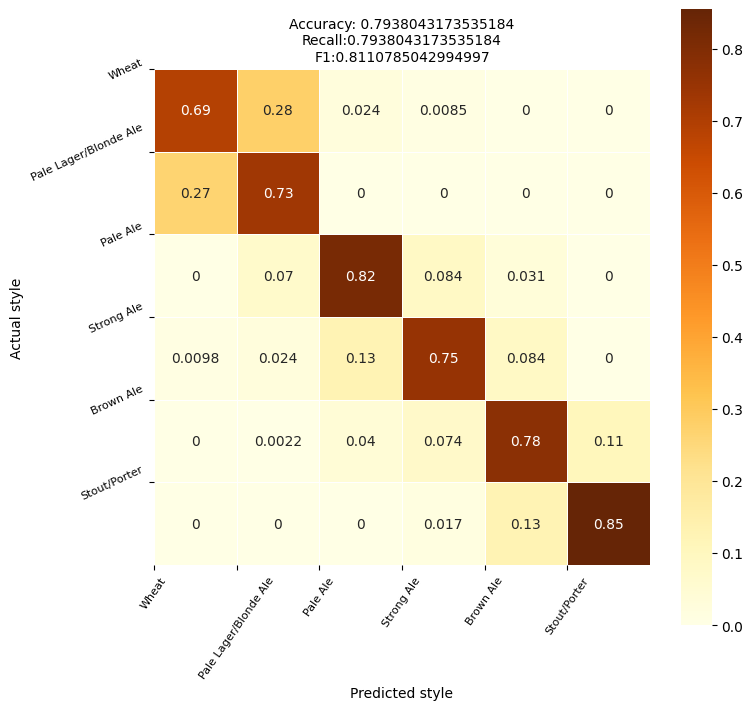

In [15]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(yc_test, predictions)}\nRecall:{recall_score(yc_test, predictions, average="weighted")}\nF1:{f1_score(yc_test, predictions, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

In [15]:
import pickle

In [17]:
# with open('../models/trained_model_lr1.pkl', 'wb') as output:
#     pickle.dump(lr1, output)

In [98]:
# with open('../models/trained_model_lr1.pkl', 'rb') as input:
#     modelo_importado = pickle.load(input) 

### Setting the IBU code column as target: second option

In [16]:
#Second experiment with ibu code
X_train=train[['ABV','IBU','Color']]
X_test=test[['ABV','IBU','Color']]

#First experiment with color code
yi_train=train['Style_ibu']
yi_test=test['Style_ibu']

In [78]:
# from sklearn.preprocessing import StandardScaler
# scalers = StandardScaler()

In [109]:
# Xtrain_scaled[col_toscale] = scalers.fit_transform(train[col_toscale])
# Xtest_scaled[col_toscale] = scalers.fit_transform(test[col_toscale])

In [17]:
rus = RandomUnderSampler(random_state=42)

X_resampleds, y_resampleds = rus.fit_resample(X_train, yi_train)

In [18]:
lr2 = LogisticRegression(max_iter=100000)
lr2.fit(X_resampleds, y_resampleds)

LogisticRegression(max_iter=100000)

In [19]:
predictions2 = lr2.predict(X_test)
predicions_probas = lr2.predict_proba(X_test)
predicions_probas

array([[8.82433812e-01, 1.17566129e-01, 1.14392659e-10, 1.35469059e-09,
        4.88828718e-14, 5.79141111e-08],
       [1.44479290e-06, 1.61873598e-05, 2.20202672e-01, 6.02815217e-01,
        4.61576183e-03, 1.72348718e-01],
       [9.85070605e-09, 2.38670534e-06, 5.83870472e-04, 9.58613262e-03,
        8.75004998e-07, 9.89826725e-01],
       ...,
       [2.58751803e-01, 6.77338880e-01, 1.61913800e-04, 2.57036067e-03,
        1.73777247e-07, 6.11768679e-02],
       [3.53795801e-25, 4.42320963e-23, 4.40272953e-02, 5.70305138e-06,
        9.55967001e-01, 6.26234453e-10],
       [2.08725376e-01, 6.22363533e-01, 1.51773788e-04, 1.14967177e-02,
        1.49906288e-07, 1.57262450e-01]])

### Evaluation
With IBU code as target

In [20]:
print('accuracy_score',accuracy_score(yi_test, predictions2))
print('precision_score',precision_score(yi_test, predictions2, average='weighted'))
print('f1_score',f1_score(yi_test, predictions2, average='weighted'))
print('recall_score',recall_score(yi_test, predictions2, average='weighted'))

accuracy_score 0.7926829268292683
precision_score 0.8472962864554971
f1_score 0.8100242874014965
recall_score 0.7926829268292683


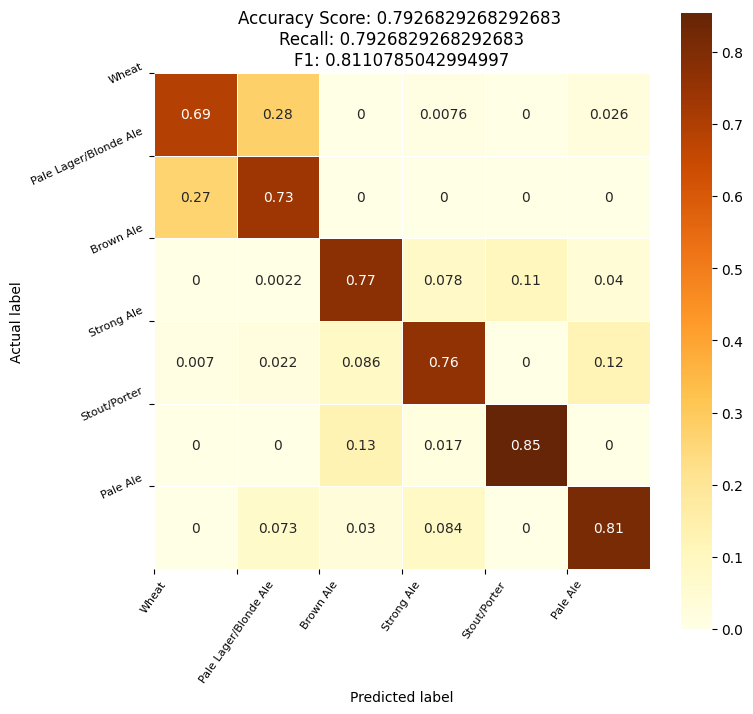

In [21]:
cms = confusion_matrix(yi_test, predictions2,normalize='true')
# print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cms, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Accuracy Score: {accuracy_score(yi_test, predictions2)} \nRecall: {recall_score(yi_test, predictions2, average="weighted")}\nF1: {f1_score(yc_test, predictions, average="weighted")}'
plt.title(all_sample_title, size = 12);
plt.xticks(ticks=range(len(ibucode.index)), labels=ibucode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(ibucode.index)), labels=ibucode['Style'],rotation=25,fontsize=8);

```Python
                Predicted Class 1 | Predicted Class 2 | ... | Predicted Class N
Actual Class 1   True Positive    | False Negative    | ... | False Negative
Actual Class 2   False Positive   | True Positive     | ... | False Negative
...             ...               | ...               | ... | ...
Actual Class N   False Positive   | False Negative    | ... | True Positive
```

Both mappings provided pretty similar results, so we'll just keep the color_code one.

In [24]:
#We can delete the ibu_code column and work with the color_code one.

beer.drop(columns='Style_ibu',inplace=True)
# beer.to_csv('../data/processed/final_dataset.csv')